# 消费行为分析与消费细分模型

## 初始化与导入数据

In [1]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from  matplotlib.colors import  rgb2hex
import numpy as np
# 解决matplotlib无法正常显示中文的问题
plt.rcParams['font.sans-serif'] = ['STHeiti'] 
# plt.rcParams['font.sans-serif'] = ['Simhei']
plt.rcParams['axes.unicode_minus'] = False
amount = pd.read_csv('consume.csv')

## 创建消费特征表

In [23]:
# 创建一个表
dict_list = []
# 统计学生消费特征
for name, group in amount.groupby(amount['CardNo']):
    money = group['Money'].agg(['sum','mean','max'])
    # 创建一条记录
    dict_t = {
        'CardNo': name,
        'AvgSurplus': format(group['Surplus'].agg(['mean'])[0], '.2f'),
        'TotalConsume': format(money[0], '.2f'),
        'AvgConsume': format(money[1], '.2f'),
        'MaxConsume': money[2],
        'Freq': group.shape[0]
    }
    dict_list.append(dict_t)
# 导出成DataFrame
evaluation = pd.DataFrame(dict_list[0:])
# 筛选掉所有消费频率低于30次的数据，认为是不正常的
evaluation = evaluation[evaluation.Freq>=30]
evaluation.to_csv('evaluation.csv')

# 基于DFM(Deposit、Frequency、Monetary)模型的K-Means分类

为了适用我们的题目，我们受到RFC模型的影响，选出了Deposit(储蓄)、Frequency(消费频率)、Monetray(消费金额)作为我们的模型评价标准。

基于此，进行K-Means分类。

## 通过Elbow Method求K-Means最佳k值

当k小于真实聚类数时，由于k的增大会大幅增加每个簇的聚合程度，故 SSE 的下降幅度会很大。

而当k到达真实聚类数时，再增加k所得到的聚合程度回报会迅速变小，所以 SSE 的下降幅度会骤减，随着k值的继续增大而趋于平缓。

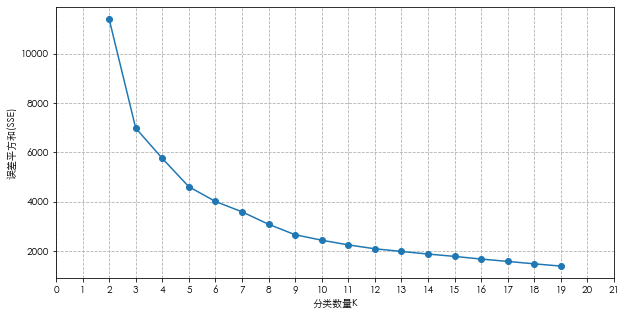

In [24]:
#你准备数据
training_data = evaluation.loc[0:, ['AvgSurplus','TotalConsume','Freq']]

# 存放每次结果的误差平方和
SSE = []
for k in range(2,20):
    km = KMeans(n_clusters=k)  # 构造聚类器
    scaler = StandardScaler()
    pipline = make_pipeline(scaler,km) 
    pipline.fit(training_data)
    SSE.append(km.inertia_)
# inertia_:样本到其最近聚类中心的平方距离之和
plt.figure(figsize=(10,5))   
plt.plot(range(2,20),SSE,'o-')
plt.xticks(range(0,22,1)) 
plt.grid(linestyle='--')
plt.xlabel("分类数量K")
plt.ylabel('误差平方和(SSE)')
plt.savefig('2-1.png')

In [ ]:
## 基于DFM(Deposit、Frequency、Monetary)模型的K-Means分类

由上图可以认为最佳的K值在5左右，我们选取5。

In [25]:
# 创建kmeans模型并标准化
km = KMeans(n_clusters=5)
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
pipline = make_pipeline(scaler,km)
# 训练kmeans模型

pipline.fit(training_data)
# 预测数据的Labels
evaluation['Labels'] = pipline.predict(training_data)
# 保存数据
evaluation.to_csv('result.csv')

## 渲染3D散点图

drawing label 0
drawing label 1
drawing label 2
drawing label 3
drawing label 4


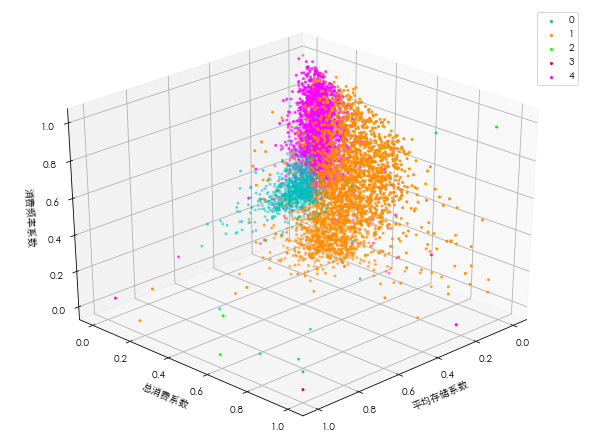

In [28]:

from sklearn.preprocessing import MinMaxScaler
fig = plt.figure(figsize=(8,6))
# 创建3D图
ax = Axes3D(fig)
colors = ['c', 'darkorange', 'lime', 'red', 'fuchsia', 'yellow']
for name, group in evaluation.groupby(evaluation['Labels']):
    std = MinMaxScaler(feature_range=(0, 1))
    x=std.fit_transform(group['AvgSurplus'].values.reshape(-1, 1))
    y=std.fit_transform(group['TotalConsume'].values.reshape(-1, 1))
    z=std.fit_transform(group['Freq'].values.reshape(-1, 1))
    print('drawing label {}'.format(name))
    ax.scatter3D(x, y, z, c=colors[name], label=name,s=4)
ax.view_init(30, 45)
ax.set_xlabel('平均存储系数')
ax.set_ylabel('总消费系数')
ax.set_zlabel('消费频率系数')
plt.legend()
plt.savefig('2-2.png')

## 结果分析

大致可以看到三大主类，还有一些松散的，我们需要找的是在最里面角落的那一类。



In [30]:
# 根据上图请自行调整，因为K-Means分类的label值不稳定，所以每次运行完前面的无比更改这个值
# 这个类是上图中所有项都最低的那一个类
group_label = 0
deep_model = evaluation[evaluation.Labels==group_label]
deep_model

,CardNo,AvgSurplus,TotalConsume,AvgConsume,MaxConsume,Freq,Labels
226,125520,126.32,446.70,2.85,18.0,157,0
406,150272,105.28,514.40,3.62,36.0,142,0
407,150282,149.80,2975.70,8.65,50.0,344,0
439,154662,106.24,413.30,2.58,10.0,160,0
468,155583,54.64,585.30,4.96,16.0,118,0
...,...,...,...,...,...,...,...
8392,186131,54.47,413.30,3.36,17.0,123,0
8394,186133,66.70,413.00,2.17,9.0,190,0
8395,186134,65.62,446.00,3.28,11.5,136,0
8396,186135,57.21,419.50,3.23,10.0,130,0


In [ ]:
## 